## README

This notebook was developed as part of the Churn model for EstrelaBet. <br>
Data Scientist: Leomar Fonseca <br>
Date: July 30th, 2025

## SETUP

In [186]:
# General packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import warnings

# Packages for model training and evaluation
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Feature selection packages
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2

# Notebook settings
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

## FUNCTIONS AND CONSTANTS

In [187]:
# Random seed for reproducibility
SEED = 101

## DATA INGESTION

In [188]:
df = pd.read_csv(r'case-files/test_dataset(in).csv')
print(f"Dataset rows: {df.shape[0]}")
print(f"Dataset columns: {df.shape[1]}")
df.head()

Dataset rows: 10000
Dataset columns: 29


,user_id,session_id,timestamp,date,hour,day_of_week,is_weekend,is_holiday,game_type,sport_type,country,device_type,payment_method,user_age,account_age_days,vip_tier,campaign_type,bet_amount,win_amount,net_result,session_length_minutes,games_played,bonus_used,deposit_amount,withdrawal_amount,previous_session_gap_hours,lifetime_deposits,lifetime_bets,avg_bet_size
0,user_001948,sess_00000068,2023-07-29T23:55:21.913140Z,7/29/2023,23,5,1,0,roulette,NaN,BR,mobile,bank_transfer,44.0,2,bronze,welcome_bonus,65.28,171.71,106.43,59,19,0,NaN,NaN,NaN,0.0,19,65.28
1,user_001628,sess_00000730,2023-08-01T01:46:56.989818Z,8/1/2023,1,1,0,0,live_dealer,NaN,DE,mobile,debit_card,NaN,5,bronze,free_spins,14.04,0.00,-14.04,57,19,0,NaN,NaN,NaN,0.0,19,14.04
2,user_001559,sess_00000311,2023-08-01T14:30:03.483604Z,8/1/2023,14,1,0,0,roulette,NaN,AU,desktop,crypto,NaN,6,bronze,none,14.63,21.90,7.27,113,37,0,NaN,NaN,NaN,0.0,37,14.63
3,user_000376,sess_00001978,2023-08-03T04:32:38.914782Z,8/3/2023,4,3,0,0,poker,NaN,UK,mobile,credit_card,35.0,4,bronze,none,13.15,30.61,17.46,63,21,0,NaN,NaN,NaN,0.0,21,13.15
4,user_000371,sess_00002519,2023-08-04T09:02:22.508701Z,8/4/2023,9,4,0,0,casino_slots,NaN,FR,tablet,e_wallet,45.0,1,bronze,welcome_bonus,115.25,0.00,-115.25,38,12,1,NaN,NaN,NaN,0.0,12,115.25


## EXPLORATORY DATA ANALYSIS

### DATA TYPES

In [189]:
# Check object types
df.dtypes

user_id                        object
session_id                     object
timestamp                      object
date                           object
hour                            int64
day_of_week                     int64
is_weekend                      int64
is_holiday                      int64
game_type                      object
sport_type                     object
country                        object
device_type                    object
payment_method                 object
user_age                      float64
account_age_days                int64
vip_tier                       object
campaign_type                  object
bet_amount                    float64
win_amount                    float64
net_result                    float64
session_length_minutes          int64
games_played                    int64
bonus_used                      int64
deposit_amount                float64
withdrawal_amount             float64
previous_session_gap_hours    float64
lifetime_dep

In [190]:
# Fixing object types and grouping types on lists
df['timestamp'] = pd.to_datetime(df['timestamp'])
lst_categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
lst_numerical_columns = df.select_dtypes(include=['number']).columns.tolist()

### FEATURE: user_id

In [191]:
df.groupby('user_id').agg(
    session_count=('session_id', 'nunique')
).reset_index().sort_values('session_count', ascending=False)

,user_id,session_count
283,user_000383,19
894,user_001255,17
359,user_000493,16
1406,user_001948,16
253,user_000341,16
...,...,...
1121,user_001562,1
1085,user_001514,1
656,user_000940,1
549,user_000773,1


In [192]:
df[df['user_id'] == 'user_000383'].sort_values('timestamp')

,user_id,session_id,timestamp,date,hour,day_of_week,is_weekend,is_holiday,game_type,sport_type,country,device_type,payment_method,user_age,account_age_days,vip_tier,campaign_type,bet_amount,win_amount,net_result,session_length_minutes,games_played,bonus_used,deposit_amount,withdrawal_amount,previous_session_gap_hours,lifetime_deposits,lifetime_bets,avg_bet_size
2202,user_000383,sess_00000154,2024-01-22 17:41:31.757755+00:00,1/22/2024,17,0,0,0,sports_betting,tennis,MX,mobile,bank_transfer,19.0,14,bronze,welcome_bonus,37.31,104.53,67.22,42,14,0,97.30,NaN,NaN,97.30,14,37.31
2432,user_000383,sess_00001071,2024-02-03 17:04:24.860062+00:00,2/3/2024,17,5,1,0,poker,NaN,MX,desktop,bank_transfer,19.0,26,bronze,welcome_bonus,12.55,0.00,-12.55,59,19,1,198.85,NaN,0.0,296.15,33,24.93
2472,user_000383,sess_00001289,2024-02-06 00:45:43.077258+00:00,2/6/2024,0,1,0,1,sports_betting,hockey,MX,tablet,bank_transfer,19.0,28,bronze,welcome_bonus,18.17,0.00,-18.17,36,12,0,NaN,NaN,0.0,296.15,45,22.68
2511,user_000383,sess_00001950,2024-02-07 21:42:26.387636+00:00,2/7/2024,21,2,0,0,sports_betting,NaN,MX,mobile,bank_transfer,19.0,30,bronze,free_spins,22.95,45.82,22.87,47,15,0,NaN,NaN,0.0,296.15,60,22.74
2578,user_000383,sess_00002322,2024-02-11 13:30:43.933269+00:00,2/11/2024,13,6,1,0,live_dealer,NaN,MX,desktop,bank_transfer,19.0,33,bronze,none,79.92,0.00,-79.92,10,3,0,NaN,NaN,0.0,296.15,63,34.18
2920,user_000383,sess_00002803,2024-02-29 18:58:04.991315+00:00,2/29/2024,18,3,0,0,live_dealer,NaN,MX,tablet,bank_transfer,19.0,52,bronze,reload_bonus,18.91,32.46,13.55,153,51,0,NaN,NaN,0.0,296.15,114,31.64
3033,user_000383,sess_00003074,2024-03-06 22:11:40.087320+00:00,3/6/2024,22,2,0,0,roulette,NaN,MX,tablet,bank_transfer,19.0,58,bronze,free_spins,80.25,167.19,86.94,215,71,1,164.18,628.71,0.0,460.33,185,NaN
3195,user_000383,sess_00003813,2024-03-14 22:34:18.835490+00:00,3/14/2024,22,3,0,1,roulette,NaN,MX,mobile,bank_transfer,19.0,66,bronze,free_spins,114.45,341.35,226.90,42,14,0,NaN,NaN,0.0,460.33,199,48.06
3251,user_000383,sess_00003909,2024-03-17 18:28:01.392869+00:00,3/17/2024,18,6,1,0,poker,NaN,MX,tablet,bank_transfer,19.0,69,silver,none,185.89,236.21,50.32,121,40,1,142.28,NaN,0.0,602.61,239,63.38
3569,user_000383,sess_00004675,2024-04-03 19:09:11.500651+00:00,4/3/2024,19,2,0,0,casino_slots,NaN,MX,tablet,credit_card,19.0,86,silver,cashback,155.51,0.00,-155.51,33,11,0,NaN,NaN,0.0,602.61,250,72.59


### FEATURE: session_id

In [193]:
# Group by session_id to see if there are repeated sessions
df.groupby('session_id').agg(
    session_count=('user_id', 'count')
).reset_index().sort_values('session_count', ascending=False)

,session_id,session_count
9983,sess_00009984,1
9982,sess_00009983,1
9981,sess_00009982,1
9980,sess_00009981,1
9979,sess_00009980,1
...,...,...
4,sess_00000005,1
3,sess_00000004,1
2,sess_00000003,1
1,sess_00000002,1


### FEATURE: (previous)session_gap_hours

In [194]:
# Calculate number of hours between sessions
df.sort_values(['user_id', 'timestamp'], inplace=True)
df['previous_session_gap_hours'] = df.groupby('user_id')['timestamp'].diff().dt.total_seconds() / 3600
df['next_session_gap_hours'] = df.groupby('user_id')['timestamp'].diff(-1).dt.total_seconds() / 3600 * (-1)
df.dropna(subset=['next_session_gap_hours'], inplace=True)
df[df['user_id'] == 'user_000383']

,user_id,session_id,timestamp,date,hour,day_of_week,is_weekend,is_holiday,game_type,sport_type,country,device_type,payment_method,user_age,account_age_days,vip_tier,campaign_type,bet_amount,win_amount,net_result,session_length_minutes,games_played,bonus_used,deposit_amount,withdrawal_amount,previous_session_gap_hours,lifetime_deposits,lifetime_bets,avg_bet_size,next_session_gap_hours
2202,user_000383,sess_00000154,2024-01-22 17:41:31.757755+00:00,1/22/2024,17,0,0,0,sports_betting,tennis,MX,mobile,bank_transfer,19.0,14,bronze,welcome_bonus,37.31,104.53,67.22,42,14,0,97.30,NaN,NaN,97.30,14,37.31,287.381417
2432,user_000383,sess_00001071,2024-02-03 17:04:24.860062+00:00,2/3/2024,17,5,1,0,poker,NaN,MX,desktop,bank_transfer,19.0,26,bronze,welcome_bonus,12.55,0.00,-12.55,59,19,1,198.85,NaN,287.381417,296.15,33,24.93,55.688394
2472,user_000383,sess_00001289,2024-02-06 00:45:43.077258+00:00,2/6/2024,0,1,0,1,sports_betting,hockey,MX,tablet,bank_transfer,19.0,28,bronze,welcome_bonus,18.17,0.00,-18.17,36,12,0,NaN,NaN,55.688394,296.15,45,22.68,44.945364
2511,user_000383,sess_00001950,2024-02-07 21:42:26.387636+00:00,2/7/2024,21,2,0,0,sports_betting,NaN,MX,mobile,bank_transfer,19.0,30,bronze,free_spins,22.95,45.82,22.87,47,15,0,NaN,NaN,44.945364,296.15,60,22.74,87.804874
2578,user_000383,sess_00002322,2024-02-11 13:30:43.933269+00:00,2/11/2024,13,6,1,0,live_dealer,NaN,MX,desktop,bank_transfer,19.0,33,bronze,none,79.92,0.00,-79.92,10,3,0,NaN,NaN,87.804874,296.15,63,34.18,437.455849
2920,user_000383,sess_00002803,2024-02-29 18:58:04.991315+00:00,2/29/2024,18,3,0,0,live_dealer,NaN,MX,tablet,bank_transfer,19.0,52,bronze,reload_bonus,18.91,32.46,13.55,153,51,0,NaN,NaN,437.455849,296.15,114,31.64,147.226416
3033,user_000383,sess_00003074,2024-03-06 22:11:40.087320+00:00,3/6/2024,22,2,0,0,roulette,NaN,MX,tablet,bank_transfer,19.0,58,bronze,free_spins,80.25,167.19,86.94,215,71,1,164.18,628.71,147.226416,460.33,185,NaN,192.377430
3195,user_000383,sess_00003813,2024-03-14 22:34:18.835490+00:00,3/14/2024,22,3,0,1,roulette,NaN,MX,mobile,bank_transfer,19.0,66,bronze,free_spins,114.45,341.35,226.90,42,14,0,NaN,NaN,192.377430,460.33,199,48.06,67.895155
3251,user_000383,sess_00003909,2024-03-17 18:28:01.392869+00:00,3/17/2024,18,6,1,0,poker,NaN,MX,tablet,bank_transfer,19.0,69,silver,none,185.89,236.21,50.32,121,40,1,142.28,NaN,67.895155,602.61,239,63.38,408.686141
3569,user_000383,sess_00004675,2024-04-03 19:09:11.500651+00:00,4/3/2024,19,2,0,0,casino_slots,NaN,MX,tablet,credit_card,19.0,86,silver,cashback,155.51,0.00,-155.51,33,11,0,NaN,NaN,408.686141,602.61,250,72.59,521.640204


### CLV (Customer Lifetime Value)

In [195]:
df['company_net_result'] = df['bet_amount'] - df['win_amount']
df.sort_values(['user_id', 'timestamp'], inplace=True)
df['clv_real'] = df.groupby('user_id')['company_net_result'].cumsum()
df['clv_tier'] = np.where(df['clv_real'] < 1000, 'bronze',
                 np.where(df['clv_real'] < 2000, 'silver',
                 np.where(df['clv_real'] < 5500, 'gold',
                 np.where(df['clv_real'] < 10000, 'platinum', 'diamond'))))
df.head()

,user_id,session_id,timestamp,date,hour,day_of_week,is_weekend,is_holiday,game_type,sport_type,country,device_type,payment_method,user_age,account_age_days,vip_tier,campaign_type,bet_amount,win_amount,net_result,session_length_minutes,games_played,bonus_used,deposit_amount,withdrawal_amount,previous_session_gap_hours,lifetime_deposits,lifetime_bets,avg_bet_size,next_session_gap_hours,company_net_result,clv_real,clv_tier
4831,user_000002,sess_00001626,2024-06-04 16:10:15.993090+00:00,6/4/2024,16,1,0,1,blackjack,NaN,MX,mobile,e_wallet,43.0,17,gold,welcome_bonus,6731.21,12678.31,5947.10,144,48,0,3802.83,NaN,NaN,3802.83,48,6731.21,20.581506,-5947.10,-5947.10,bronze
4844,user_000002,sess_00004881,2024-06-05 12:45:09.413048+00:00,6/5/2024,12,2,0,0,sports_betting,baseball,MX,desktop,e_wallet,43.0,18,gold,free_spins,1535.45,0.00,-1535.45,146,48,0,5945.27,NaN,20.581506,9748.10,96,4133.33,11.791148,1535.45,-4411.65,bronze
4859,user_000002,sess_00005677,2024-06-06 00:32:37.544885+00:00,6/6/2024,0,3,0,0,blackjack,NaN,MX,mobile,e_wallet,43.0,19,platinum,none,1112.86,2354.28,1241.42,373,124,0,3415.60,NaN,11.791148,13163.70,220,3126.51,5.021967,-1241.42,-5653.07,bronze
4866,user_000002,sess_00005881,2024-06-06 05:33:56.626556+00:00,6/6/2024,5,3,0,0,poker,NaN,MX,desktop,e_wallet,43.0,19,platinum,welcome_bonus,1234.70,0.00,-1234.70,181,60,0,5198.37,NaN,5.021967,18362.07,280,2653.56,11.922269,1234.70,-4418.37,bronze
4879,user_000002,sess_00007201,2024-06-06 17:29:16.793811+00:00,6/6/2024,17,3,0,0,sports_betting,tennis,MX,tablet,NaN,43.0,20,platinum,welcome_bonus,49259.73,0.00,-49259.73,121,40,1,2671.07,NaN,11.922269,21033.14,320,11974.79,17.013450,49259.73,44841.36,diamond


### CHURN (target variable)

Percent of total churn sessions: 21.28%
Percent of sessions in bronze tier: 8257
Percent of churn sessions in bronze tier: 22.04%


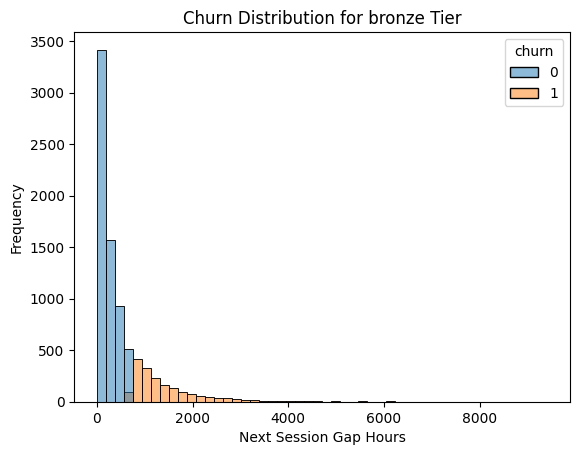

Percent of sessions in diamond tier: 73
Percent of churn sessions in diamond tier: 0.00%


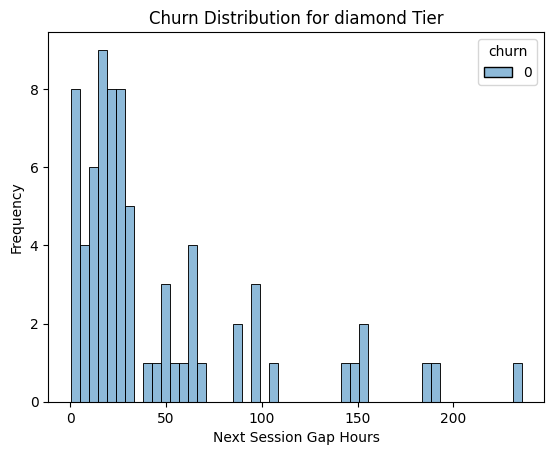

Percent of sessions in gold tier: 85
Percent of churn sessions in gold tier: 0.00%


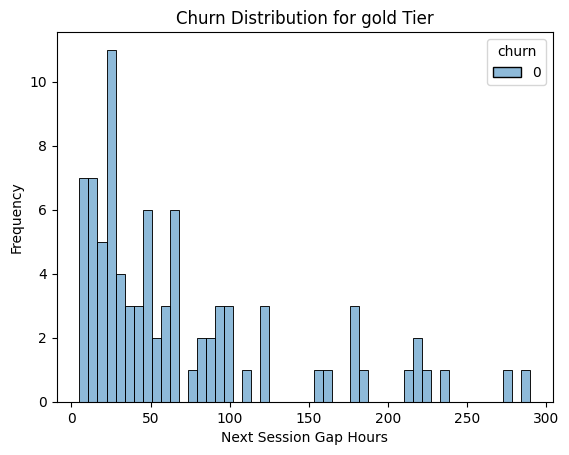

Percent of sessions in silver tier: 122
Percent of churn sessions in silver tier: 0.00%


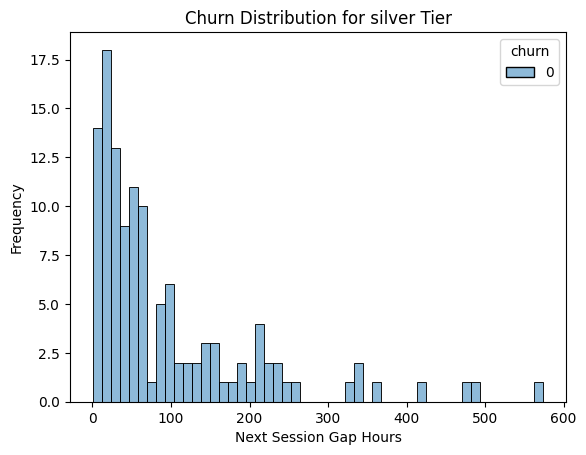

Percent of sessions in platinum tier: 17
Percent of churn sessions in platinum tier: 0.00%


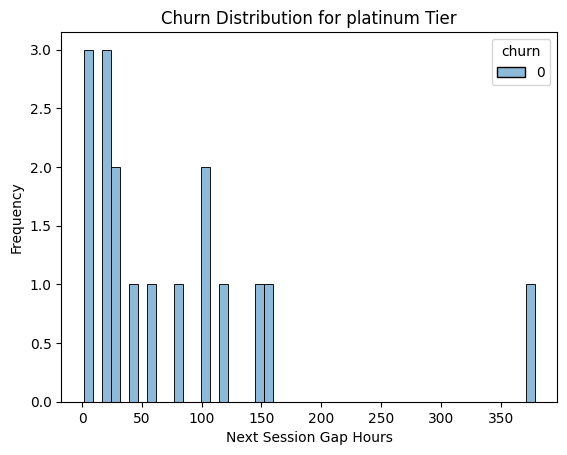

In [196]:
df['churn'] = (df['next_session_gap_hours'] > 24 * 30).astype(int)
print(f"Percent of total churn sessions: {df[df['churn'] == 1].shape[0]/df.shape[0] * 100:.2f}%")
for tier in df['clv_tier'].unique():
    print(f"Percent of sessions in {tier} tier: {df[(df['clv_tier'] == tier)].shape[0]}")
    print(f"Percent of churn sessions in {tier} tier: {df[(df['clv_tier'] == tier) & (df['churn'] == 1)].shape[0] / df[df['clv_tier'] == tier].shape[0] * 100:.2f}%")
    sns.histplot(data=df[df['clv_tier'] == tier], x='next_session_gap_hours', bins=50, hue='churn')
    plt.title(f"Churn Distribution for {tier} Tier")
    plt.xlabel("Next Session Gap Hours")
    plt.ylabel("Frequency")
    plt.show()

### CATEGORICAL FEATURES

In [197]:
for feature in [x for x in lst_categorical_columns if x not in ['session_id', 'user_id', 'date']]:
    print(f'Feature: {feature} - Unique values: {df[feature].nunique()}')
    print("Value counts:")
    print(df[feature].value_counts(normalize=True, dropna=False))
    print("\n")

Feature: game_type - Unique values: 6
Value counts:
game_type
poker             0.172902
live_dealer       0.172785
blackjack         0.168576
sports_betting    0.160627
casino_slots      0.153846
roulette          0.151157
NaN               0.020108
Name: proportion, dtype: float64


Feature: sport_type - Unique values: 7
Value counts:
sport_type
NaN           0.843933
basketball    0.023732
golf          0.023030
tennis        0.022446
baseball      0.022329
soccer        0.021744
hockey        0.021627
football      0.021160
Name: proportion, dtype: float64


Feature: country - Unique values: 10
Value counts:
country
UK     0.109072
CA     0.104980
FR     0.104863
US     0.103577
MX     0.102876
BR     0.102759
ES     0.096212
AU     0.090952
DE     0.088263
IT     0.086626
NaN    0.009820
Name: proportion, dtype: float64


Feature: device_type - Unique values: 3
Value counts:
device_type
tablet     0.335983
desktop    0.333762
mobile     0.330255
Name: proportion, dtype: float64




### NUMERICAL FEATURES

Feature: hour - Null values: 0


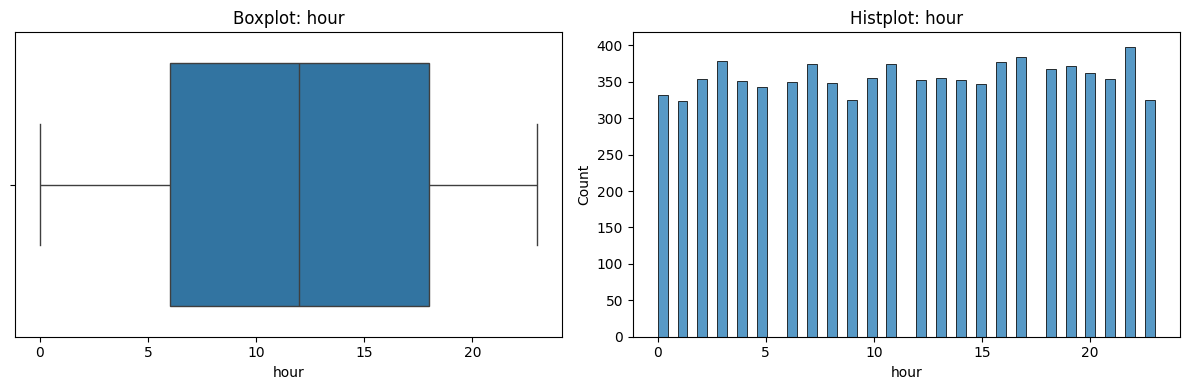

Feature: day_of_week - Null values: 0


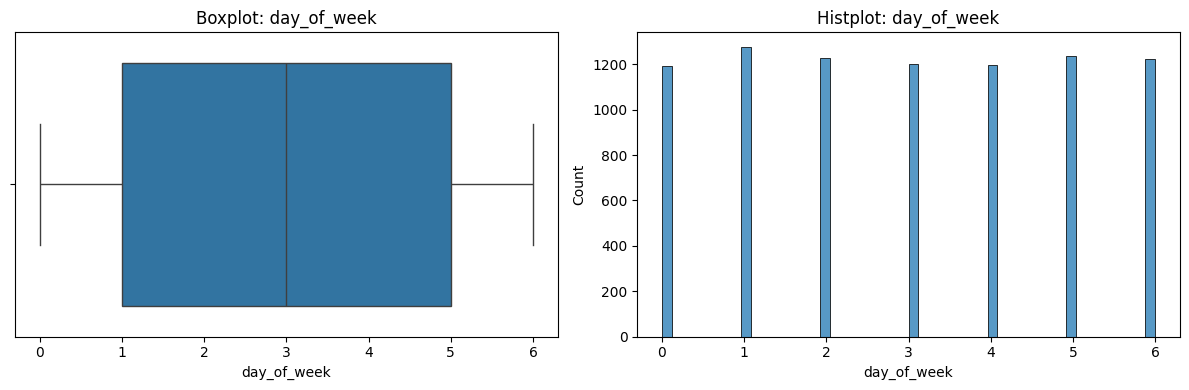

Feature: is_weekend - Null values: 0


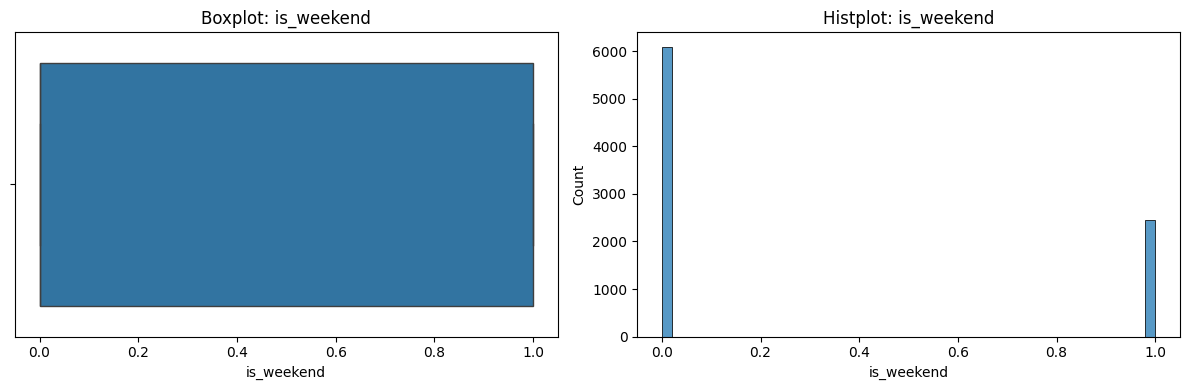

Feature: is_holiday - Null values: 0


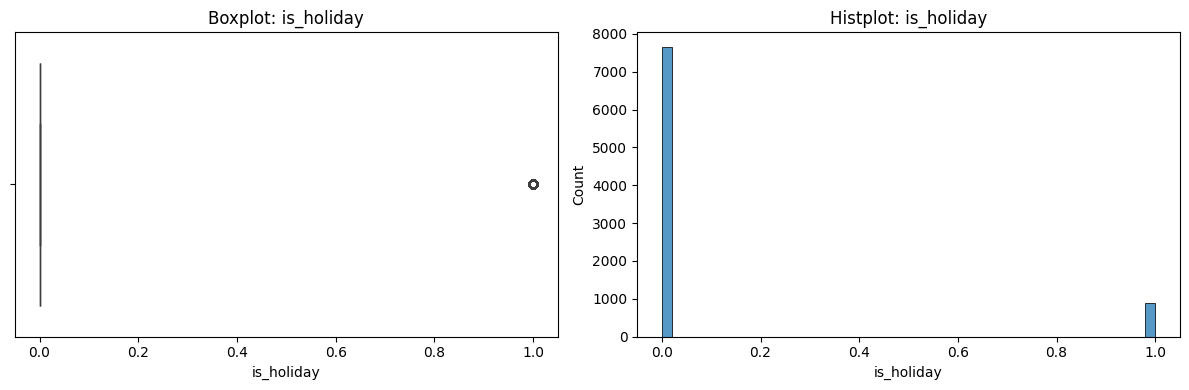

Feature: user_age - Null values: 649


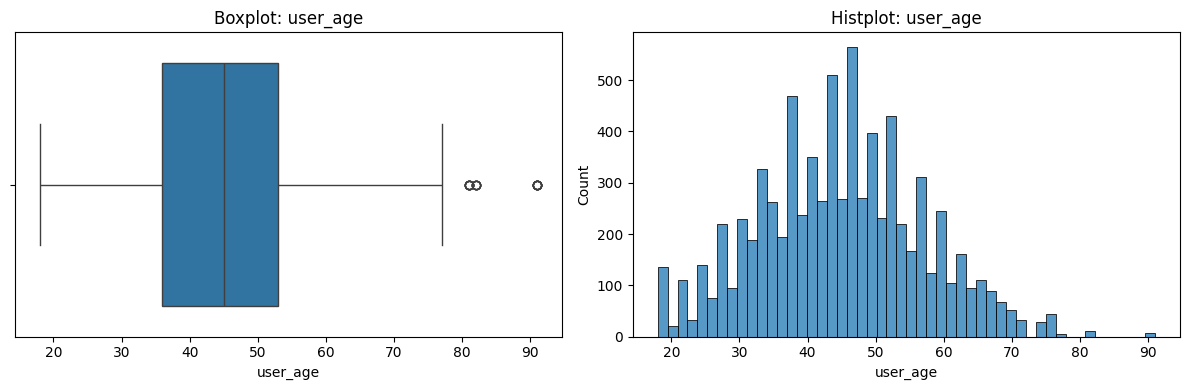

Feature: account_age_days - Null values: 0


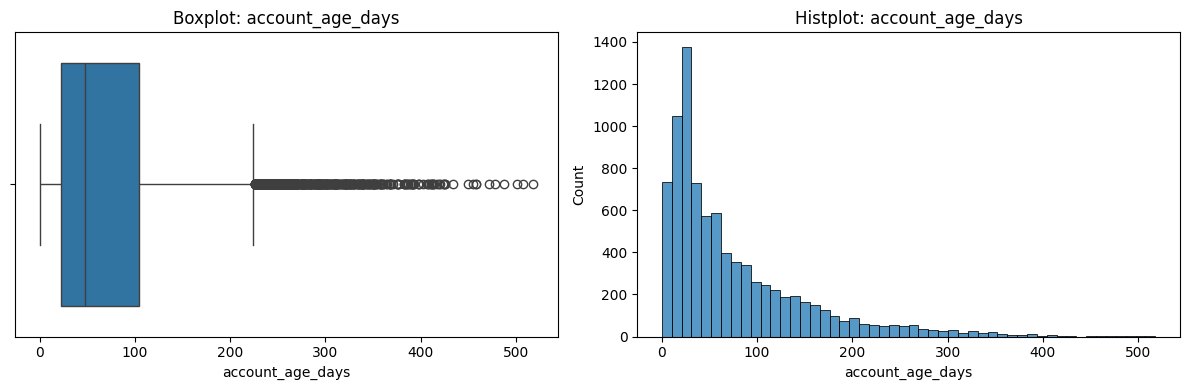

Feature: bet_amount - Null values: 0


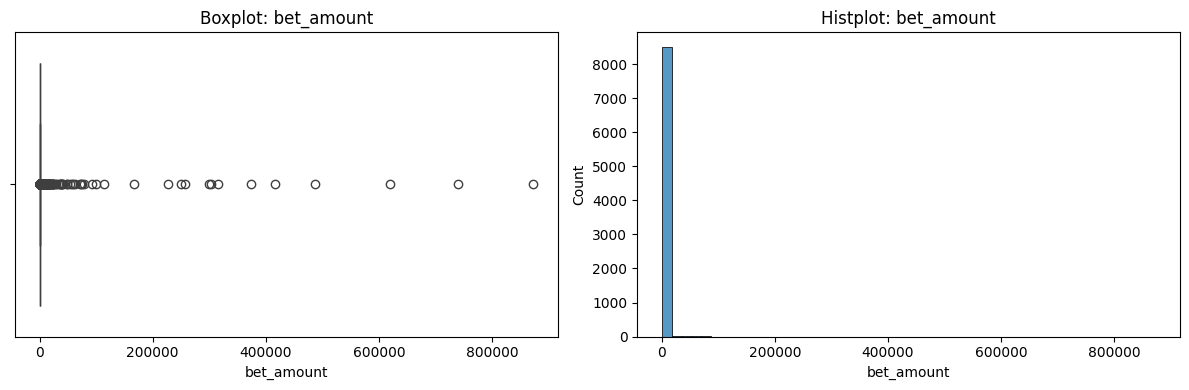

Feature: win_amount - Null values: 0


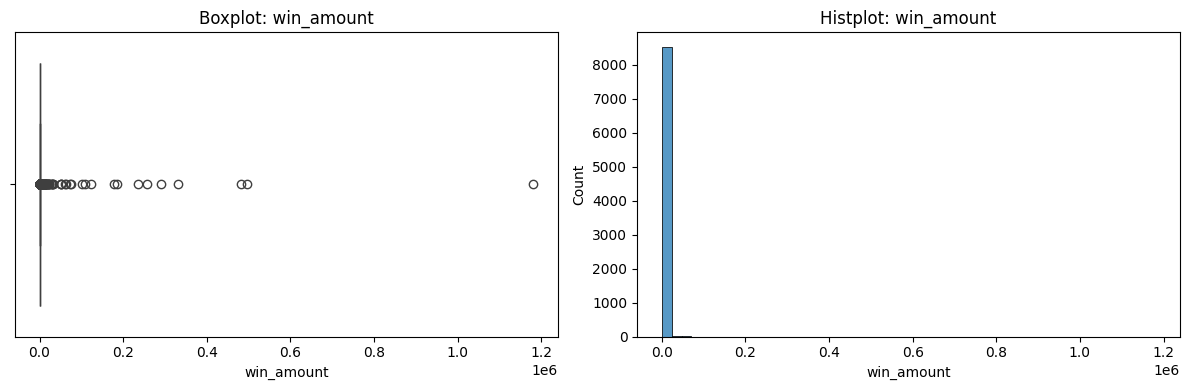

Feature: net_result - Null values: 0


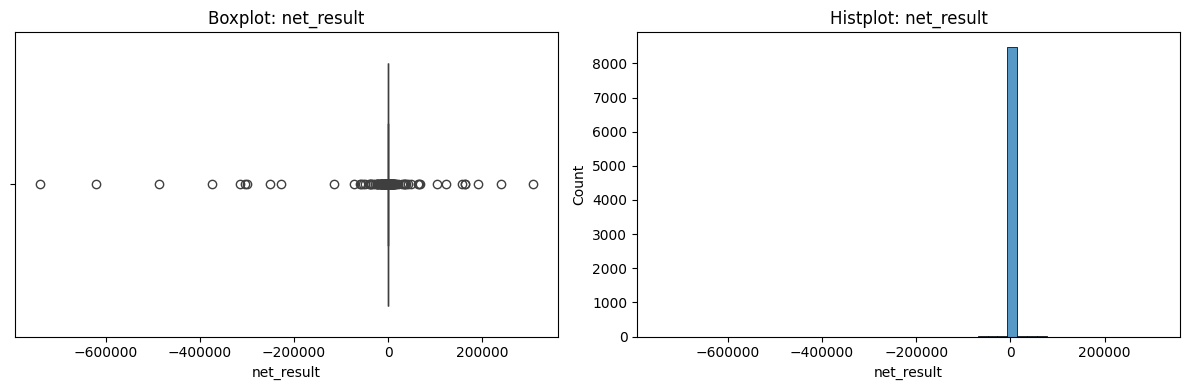

Feature: session_length_minutes - Null values: 0


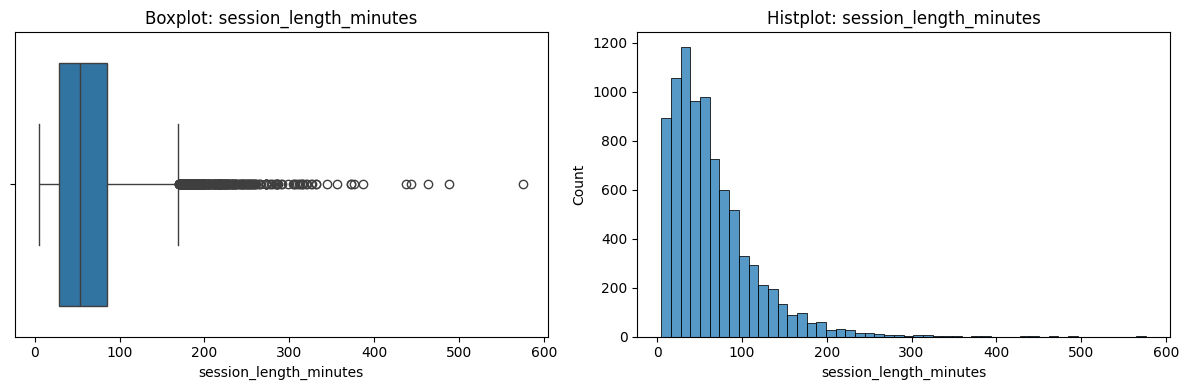

Feature: games_played - Null values: 0


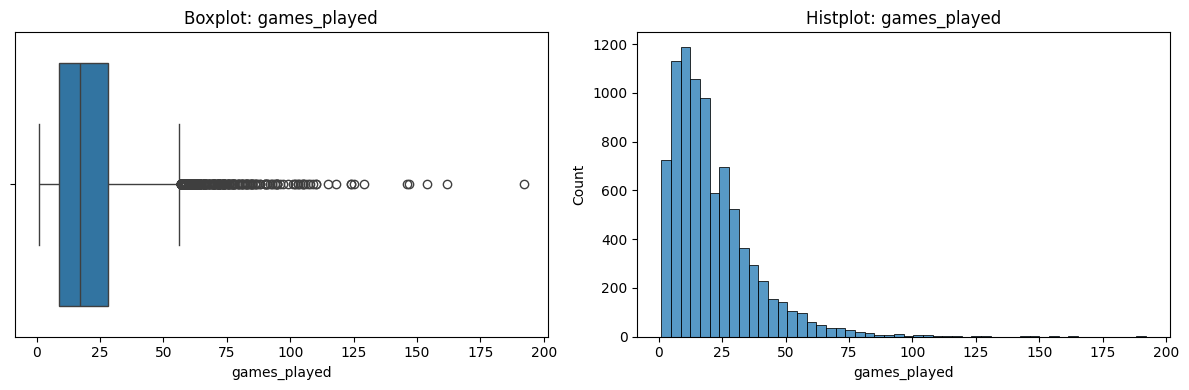

Feature: bonus_used - Null values: 0


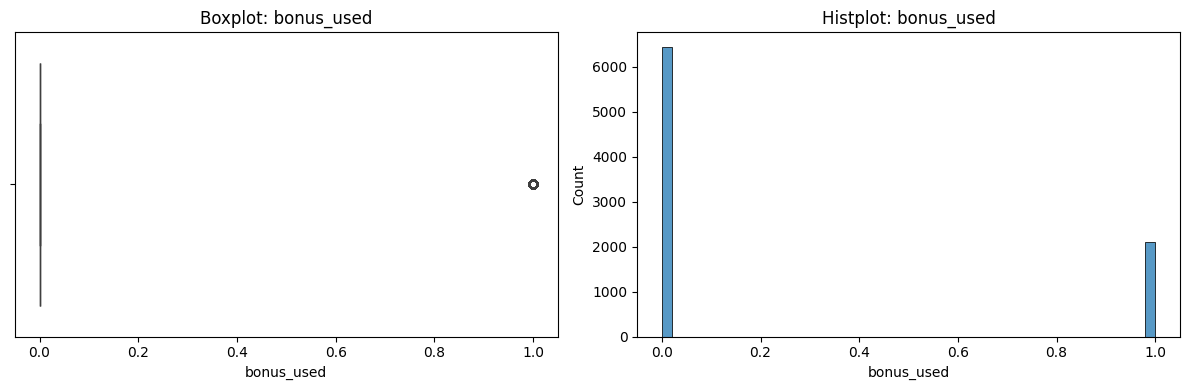

Feature: deposit_amount - Null values: 6169


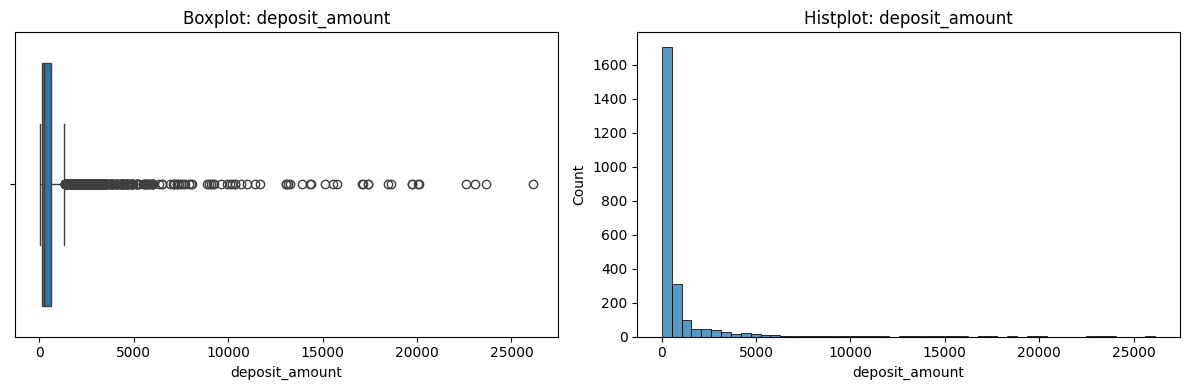

Feature: withdrawal_amount - Null values: 7882


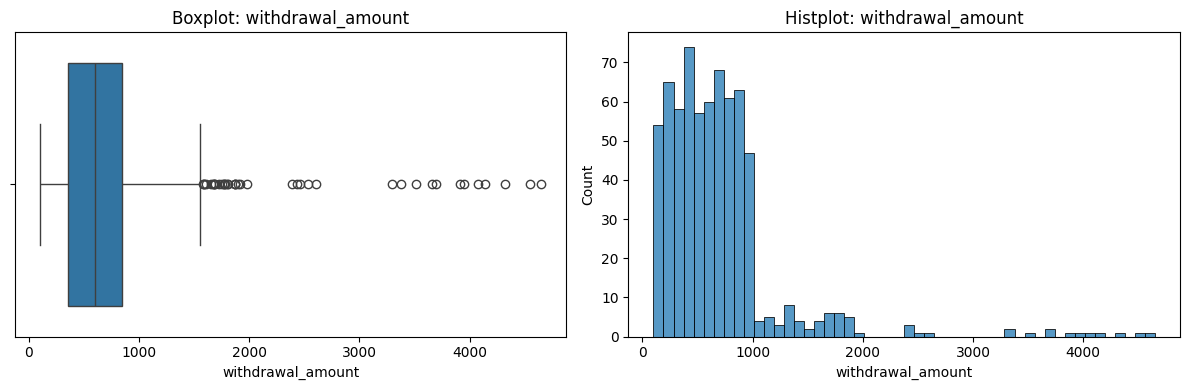

Feature: previous_session_gap_hours - Null values: 1419


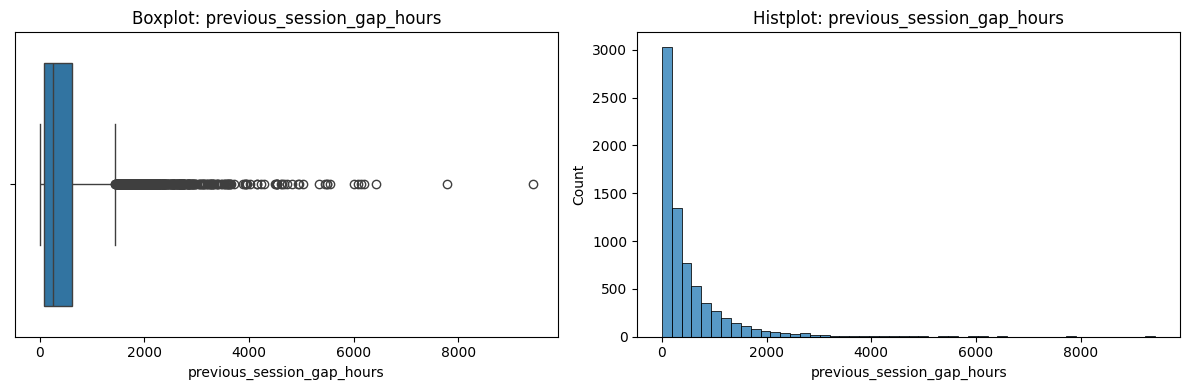

Feature: lifetime_deposits - Null values: 0


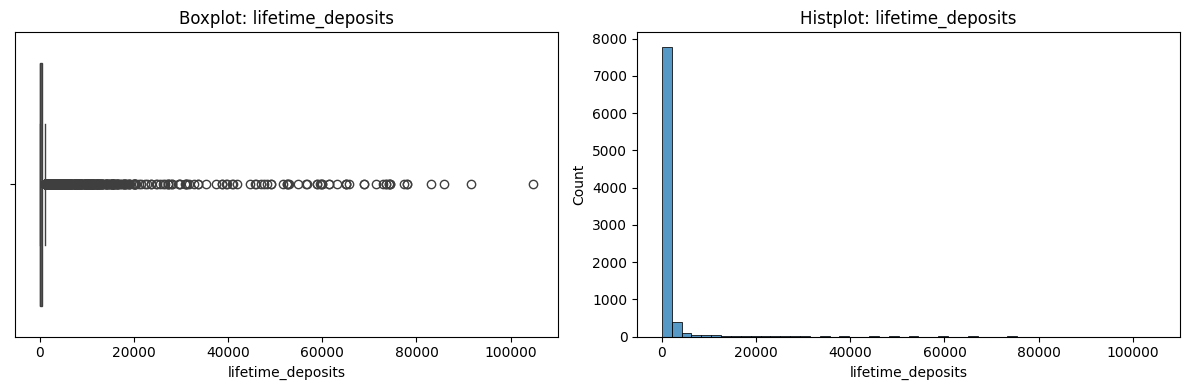

Feature: lifetime_bets - Null values: 0


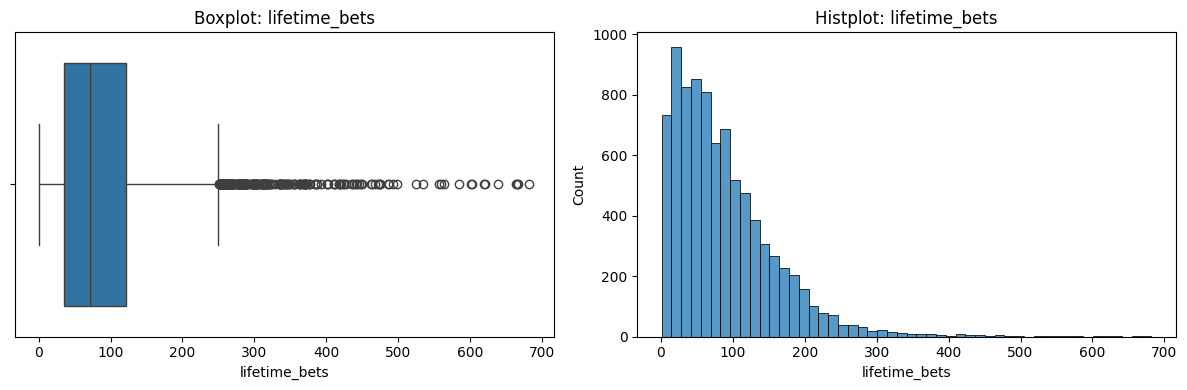

Feature: avg_bet_size - Null values: 388


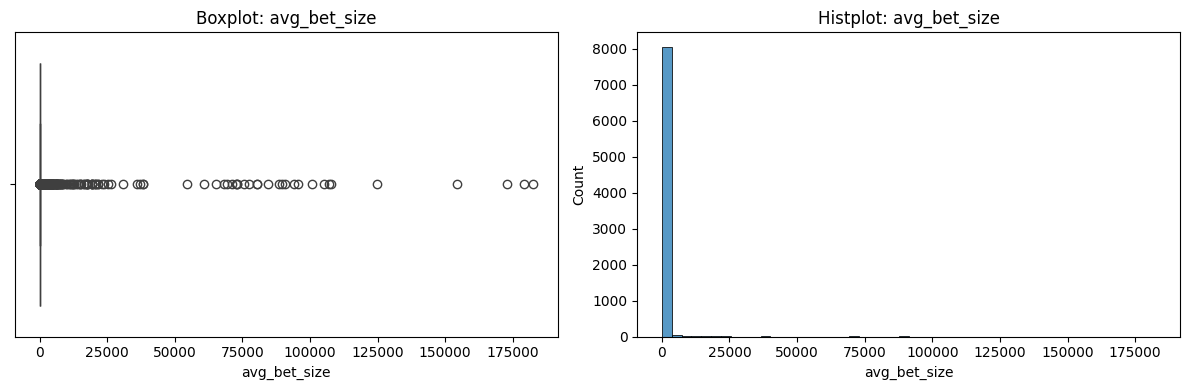

In [198]:
for feature in lst_numerical_columns:
    print(f'Feature: {feature} - Null values: {df[feature].isnull().sum()}')
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.boxplot(x=df[feature], ax=axes[0])
    axes[0].set_title(f'Boxplot: {feature}')
    sns.histplot(df[feature], bins=50, ax=axes[1])
    axes[1].set_title(f'Histplot: {feature}')
    plt.tight_layout()
    plt.show()

## FEATURE ENGINEERING

In [199]:
# Encoding categorical features
lst_columns_to_encode = ['hour', 'day_of_week', 'is_weekend', 'is_holiday', 'bonus_used'] + [x for x in lst_categorical_columns if x not in ['session_id', 'user_id', 'date']]

# Apply frequency encoding
for feature in [x for x in lst_categorical_columns if x not in ['session_id', 'user_id', 'date']]:
    freq = df[feature].value_counts(normalize=True, dropna=False)
    df[f'frequency_encoded_{feature}'] = df[feature].map(freq)

df = pd.get_dummies(df, columns=lst_columns_to_encode, drop_first=True, dummy_na=True, dtype=int)

In [200]:
pandas_cut_bins = {
    'user_age' : 10,
    'account_age_days' : 10,
    'bet_amount' : 10,
    'win_amount' : 10,
    'net_result' : 10,
    'session_length_minutes' : 10,
    'games_played' : 10,
    'deposit_amount' : 10,
    'withdrawal_amount' : 10,
    'lifetime_deposits' : 10,
    'lifetime_bets' : 10,
    'avg_bet_size' : 10
}
for feature, bins in pandas_cut_bins.items():
    df[feature] = df[feature].fillna(df[feature].median())
    df[f"binning_{feature}"] = pd.cut(df[feature], bins=bins, labels=False)

df['loss'] = np.where(df['net_result'] < 0, 1, 0)
df['net_result'] = df['net_result'].abs()

In [201]:
df.head()

,user_id,session_id,timestamp,date,user_age,account_age_days,bet_amount,win_amount,net_result,session_length_minutes,games_played,deposit_amount,withdrawal_amount,previous_session_gap_hours,lifetime_deposits,lifetime_bets,avg_bet_size,next_session_gap_hours,company_net_result,clv_real,clv_tier,churn,frequency_encoded_game_type,frequency_encoded_sport_type,frequency_encoded_country,frequency_encoded_device_type,frequency_encoded_payment_method,frequency_encoded_vip_tier,frequency_encoded_campaign_type,hour_1.0,hour_2.0,hour_3.0,hour_4.0,hour_5.0,hour_6.0,hour_7.0,hour_8.0,hour_9.0,hour_10.0,hour_11.0,hour_12.0,hour_13.0,hour_14.0,hour_15.0,hour_16.0,hour_17.0,hour_18.0,hour_19.0,hour_20.0,hour_21.0,hour_22.0,hour_23.0,hour_nan,day_of_week_1.0,day_of_week_2.0,day_of_week_3.0,day_of_week_4.0,day_of_week_5.0,day_of_week_6.0,day_of_week_nan,is_weekend_1.0,is_weekend_nan,is_holiday_1.0,is_holiday_nan,bonus_used_1.0,bonus_used_nan,game_type_casino_slots,game_type_live_dealer,game_type_poker,game_type_roulette,game_type_sports_betting,game_type_nan,sport_type_basketball,sport_type_football,sport_type_golf,sport_type_hockey,sport_type_soccer,sport_type_tennis,sport_type_nan,country_BR,country_CA,country_DE,country_ES,country_FR,country_IT,country_MX,country_UK,country_US,country_nan,device_type_mobile,device_type_tablet,device_type_nan,payment_method_credit_card,payment_method_crypto,payment_method_debit_card,payment_method_e_wallet,payment_method_nan,vip_tier_diamond,vip_tier_gold,vip_tier_platinum,vip_tier_silver,vip_tier_nan,campaign_type_free_spins,campaign_type_none,campaign_type_reload_bonus,campaign_type_welcome_bonus,campaign_type_nan,binning_user_age,binning_account_age_days,binning_bet_amount,binning_win_amount,binning_net_result,binning_session_length_minutes,binning_games_played,binning_deposit_amount,binning_withdrawal_amount,binning_lifetime_deposits,binning_lifetime_bets,binning_avg_bet_size,loss
4831,user_000002,sess_00001626,2024-06-04 16:10:15.993090+00:00,6/4/2024,43.0,17,6731.21,12678.31,5947.10,144,48,3802.83,604.755,NaN,3802.83,48,6731.21,20.581506,-5947.10,-5947.10,bronze,0,0.168576,0.843933,0.102876,0.330255,0.206453,0.067220,0.196282,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,3,0,0,0,7,2,2,1,1,0,0,0,0
4844,user_000002,sess_00004881,2024-06-05 12:45:09.413048+00:00,6/5/2024,43.0,18,1535.45,0.00,1535.45,146,48,5945.27,604.755,20.581506,9748.10,96,4133.33,11.791148,1535.45,-4411.65,bronze,0,0.160627,0.022329,0.102876,0.333762,0.206453,0.067220,0.207739,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,3,0,0,0,7,2,2,2,1,0,1,0,1
4859,user_000002,sess_00005677,2024-06-06 00:32:37.544885+00:00,6/6/2024,43.0,19,1112.86,2354.28,1241.42,373,124,3415.60,604.755,11.791148,13163.70,220,3126.51,5.021967,-1241.42,-5653.07,bronze,0,0.168576,0.843933,0.102876,0.330255,0.206453,0.019757,0.198036,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,3,0,0,0,7,6,6,1,1,1,3,0,0
4866,user_000002,sess_00005881,2024-06-06 05:33:56.626556+00:00,6/6/2024,43.0,19,1234.70,0.00,1234.70,181,60,5198.37,604.755,5.021967,18362.07,280,2653.56,11.922269,1234.70,-4418.37,bronze,0,0.172902,0.843933,0.102876,0.333762,0.206453,0.019757,0.196282,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,3,0,0,0,7,3,3,1,1,1,4,0,1
4879,user_000002,sess_00007201,2024-06-06 17:29:16.793811+00:00,6/6/2024,43.0,20,49259.73,0.00,49259.73,121,40,2671.07,604.755,11.922269,21033.14,320,11974.79,17.013450,49259.73,44841.36,diamond,0,0.160627,0.022446,0.102876,0.335983,0.028291,0.019757,0.196282,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,

## FEATURE SELECTION

In [202]:
X = df.drop(['user_id', 'session_id', 'timestamp', 'date', 'churn', 'previous_session_gap_hours', 'clv_real', 'clv_tier', 'company_net_result', 'next_session_gap_hours'], axis=1)
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED, stratify=y)

In [203]:
display(y_train.value_counts(normalize=False), y_test.value_counts(normalize=False))
display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

churn
0    5050
1    1365
Name: count, dtype: int64

churn
0    1684
1     455
Name: count, dtype: int64

churn
0    0.787217
1    0.212783
Name: proportion, dtype: float64

churn
0    0.787284
1    0.212716
Name: proportion, dtype: float64

In [204]:
# Implement SelectKBest for feature selection
from sklearn.feature_selection import SelectKBest, chi2
selector = SelectKBest(chi2, k=30)
selector.fit(X_train, y_train)
selected_feature_selectkbest = X_train.columns[selector.get_support()].tolist()

In [205]:
# Implement Boruta for feature selection
rf = RandomForestClassifier(random_state=SEED)
boruta_selector = BorutaPy(
    rf,
    n_estimators='auto',
    verbose=2,
    random_state=SEED,
    max_iter=100,
    alpha=0.05,
)
boruta_selector.fit(X_train.values, y_train.values)
selected_feature_boruta = X_train.columns[boruta_selector.support_].tolist()

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	110
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	110
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	110
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	110
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	110
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	110
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	110
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	104
Iteration: 	9 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	104
Iteration: 	10 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	104
Iteration: 	11 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	104
Iteration: 	12 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	104
Iteration: 	13 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	104
Iteration: 	14 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	104
Iteration: 	15 / 100
Confirmed: 	4
Tentative: 	2
Rejected: 	104
Iteration: 	16 / 100
Confirmed: 	4
Tentative: 	2


In [206]:
# Final selected features
selected_feature_names = list(set(selected_feature_selectkbest + selected_feature_boruta))
X_train = X_train[selected_feature_names]
X_test = X_test[selected_feature_names]

## MODEL TRAINING

### CLASS WEIGHTS

In [217]:
# Calculate scale_pos_weight based on class imbalance
total = len(y_train)
pos = y_train.sum()
neg = total - pos
scale_pos_weight = neg / pos 

# Coefficient of balancing precision and recall
coefficient = 0.85
scale_pos_weight = scale_pos_weight * coefficient
print('Scale pos weight:', scale_pos_weight)

Scale pos weight: 3.1446886446886446


### BASELINE

In [218]:
# Logistic Regression as baseline model
baseline_model = LogisticRegression(max_iter=1000, random_state=SEED, class_weight={0: 1, 1: scale_pos_weight})
baseline_model.fit(X_train, y_train)

# Calculate performance metrics for training set
y_pred = baseline_model.predict(X_train[[*selected_feature_names]])
print("Training set performance metrics:")
print("Accuracy:", accuracy_score(y_train, y_pred))
print("Precision:", precision_score(y_train, y_pred))
print("Recall:", recall_score(y_train, y_pred))
print("F1 Score:", f1_score(y_train, y_pred))
print("\n")

# Calculate performance metrics for testing set
y_pred = baseline_model.predict(X_test[[*selected_feature_names]])
print("Testing set performance metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Training set performance metrics:
Accuracy: 0.6132501948558067
Precision: 0.3213828425096031
Recall: 0.7355311355311356
F1 Score: 0.4473156605034529


Testing set performance metrics:
Accuracy: 0.595137914913511
Precision: 0.30484330484330485
Recall: 0.7054945054945055
F1 Score: 0.42572944297082227


### PREDICTOR

In [ ]:
# Parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [10, 50, 100, 500, 1000, 2000],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [4, 6, 8],
    # 'subsample': [0.6, 0.8, 1.0],
    # 'colsample_bytree': [0.6, 0.8, 1.0]
}

# Instantiate XGBClassifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=SEED,
    scale_pos_weight=scale_pos_weight
)

# Run GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='recall',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Calculate performance metrics for training set
y_pred = best_model.predict(X_train[[*selected_feature_names]])
print("Training set performance metrics:")
print("Accuracy:", accuracy_score(y_train, y_pred))
print("Precision:", precision_score(y_train, y_pred))
print("Recall:", recall_score(y_train, y_pred))
print("F1 Score:", f1_score(y_train, y_pred))
print("\n")

# Calculate performance metrics for testing set
y_pred = best_model.predict(X_test[[*selected_feature_names]])
print("Testing set performance metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Training set performance metrics:
Accuracy: 0.5917381137957911
Precision: 0.32505580357142855
Recall: 0.8534798534798534
F1 Score: 0.47080218225904225


Testing set performance metrics:
Accuracy: 0.5572697522206639
Precision: 0.29465776293823037
Recall: 0.7758241758241758
F1 Score: 0.42710223835450695


In [220]:
# Show feature importance
feature_importances = pd.DataFrame(
    {'feature': X_train.columns, 'importance': best_model.feature_importances_}
).sort_values('importance', ascending=False)
feature_importances

,feature,importance
1,lifetime_deposits,0.399481
17,avg_bet_size,0.123318
19,hour_7.0,0.059468
12,hour_10.0,0.058885
21,account_age_days,0.052366
28,hour_23.0,0.050652
25,net_result,0.037199
2,bet_amount,0.035105
26,lifetime_bets,0.033191
0,session_length_minutes,0.027862


In [223]:
# # Save best model
with open('best_xgb_model.pkl', 'wb') as f:
    joblib.dump(best_model, f)

## BUSINESS ANALYSIS

In [224]:
# Load model
with open('best_xgb_model.pkl', 'rb') as f:
    best_model = joblib.load(f)

# Score the model on original dataframe
df['predicted_churn'] = best_model.predict(X[selected_feature_names])
df['predicted_churn_proba'] = best_model.predict_proba(X[selected_feature_names])[:, 1]
df.head()

,user_id,session_id,timestamp,date,user_age,account_age_days,bet_amount,win_amount,net_result,session_length_minutes,games_played,deposit_amount,withdrawal_amount,previous_session_gap_hours,lifetime_deposits,lifetime_bets,avg_bet_size,next_session_gap_hours,company_net_result,clv_real,clv_tier,churn,frequency_encoded_game_type,frequency_encoded_sport_type,frequency_encoded_country,frequency_encoded_device_type,frequency_encoded_payment_method,frequency_encoded_vip_tier,frequency_encoded_campaign_type,hour_1.0,hour_2.0,hour_3.0,hour_4.0,hour_5.0,hour_6.0,hour_7.0,hour_8.0,hour_9.0,hour_10.0,hour_11.0,hour_12.0,hour_13.0,hour_14.0,hour_15.0,hour_16.0,hour_17.0,hour_18.0,hour_19.0,hour_20.0,hour_21.0,hour_22.0,hour_23.0,hour_nan,day_of_week_1.0,day_of_week_2.0,day_of_week_3.0,day_of_week_4.0,day_of_week_5.0,day_of_week_6.0,day_of_week_nan,is_weekend_1.0,is_weekend_nan,is_holiday_1.0,is_holiday_nan,bonus_used_1.0,bonus_used_nan,game_type_casino_slots,game_type_live_dealer,game_type_poker,game_type_roulette,game_type_sports_betting,game_type_nan,sport_type_basketball,sport_type_football,sport_type_golf,sport_type_hockey,sport_type_soccer,sport_type_tennis,sport_type_nan,country_BR,country_CA,country_DE,country_ES,country_FR,country_IT,country_MX,country_UK,country_US,country_nan,device_type_mobile,device_type_tablet,device_type_nan,payment_method_credit_card,payment_method_crypto,payment_method_debit_card,payment_method_e_wallet,payment_method_nan,vip_tier_diamond,vip_tier_gold,vip_tier_platinum,vip_tier_silver,vip_tier_nan,campaign_type_free_spins,campaign_type_none,campaign_type_reload_bonus,campaign_type_welcome_bonus,campaign_type_nan,binning_user_age,binning_account_age_days,binning_bet_amount,binning_win_amount,binning_net_result,binning_session_length_minutes,binning_games_played,binning_deposit_amount,binning_withdrawal_amount,binning_lifetime_deposits,binning_lifetime_bets,binning_avg_bet_size,loss,predicted_churn,predicted_churn_proba
4831,user_000002,sess_00001626,2024-06-04 16:10:15.993090+00:00,6/4/2024,43.0,17,6731.21,12678.31,5947.10,144,48,3802.83,604.755,NaN,3802.83,48,6731.21,20.581506,-5947.10,-5947.10,bronze,0,0.168576,0.843933,0.102876,0.330255,0.206453,0.067220,0.196282,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,3,0,0,0,7,2,2,1,1,0,0,0,0,0,0.058755
4844,user_000002,sess_00004881,2024-06-05 12:45:09.413048+00:00,6/5/2024,43.0,18,1535.45,0.00,1535.45,146,48,5945.27,604.755,20.581506,9748.10,96,4133.33,11.791148,1535.45,-4411.65,bronze,0,0.160627,0.022329,0.102876,0.333762,0.206453,0.067220,0.207739,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,3,0,0,0,7,2,2,2,1,0,1,0,1,0,0.058755
4859,user_000002,sess_00005677,2024-06-06 00:32:37.544885+00:00,6/6/2024,43.0,19,1112.86,2354.28,1241.42,373,124,3415.60,604.755,11.791148,13163.70,220,3126.51,5.021967,-1241.42,-5653.07,bronze,0,0.168576,0.843933,0.102876,0.330255,0.206453,0.019757,0.198036,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,3,0,0,0,7,6,6,1,1,1,3,0,0,0,0.058755
4866,user_000002,sess_00005881,2024-06-06 05:33:56.626556+00:00,6/6/2024,43.0,19,1234.70,0.00,1234.70,181,60,5198.37,604.755,5.021967,18362.07,280,2653.56,11.922269,1234.70,-4418.37,bronze,0,0.172902,0.843933,0.102876,0.333762,0.206453,0.019757,0.196282,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,3,0,0,0,7,3,3,1,1,1,4,0,1,0,0.058755
4879,user_000002,sess_00007201,2024-06-06 17:29:16.793811+00:00,6/6/2024,43.0,20,49259.73,0.00,49259.73,121,40,2671.07,604.755,11.922269,21033.14,320,11974.79,17.013450,49259.73,44841.36,diamond,0,0.160627,0.022446,0.102876,0.335983,0.0